In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings

import numpy as np

from astropy.table import Table
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib import rcParams

from scipy import interpolate
from scipy.optimize import brent, curve_fit
from scipy.optimize import minimize

import emcee
import corner

from riker import visual

warnings.filterwarnings("ignore")
rnd = np.random.RandomState(seed=42)


In [51]:
from priors import TopHat, StudentT
from ensemble import reinitialize_ball

In [52]:
## Read in the data from Xiao-Ya 

alf_results = fits.open('alf_all2.fits') 

print(alf_results.info())

log_sig_cen = alf_results[8].data 
log_sig_cen_err = alf_results[9].data 

fe_h = alf_results[4].data
fe_h_err = alf_results[7].data

mg_fe = alf_results[2].data
mg_fe_err = alf_results[5].data

Filename: alf_all2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (2,)   float64   
  1  INFO          1 BinTableHDU     11   853R x 1C   [32A]   
  2  MG/FE         1 ImageHDU         8   (853, 3)   float64   
  3  MGH           1 ImageHDU         8   (853, 3)   float64   
  4  FEH           1 ImageHDU         8   (853, 3)   float64   
  5  MG/FE_ERR     1 ImageHDU         8   (853, 3)   float64   
  6  MGH_ERR       1 ImageHDU         8   (853, 3)   float64   
  7  FEH_ERR       1 ImageHDU         8   (853, 3)   float64   
  8  SIGMA_CEN     1 ImageHDU         7   (853,)   float32   
  9  SIGMA_CEN_ERR    1 ImageHDU         7   (853,)   float64   
None


In [60]:
# Filter the data
def emcee_fit(x, y, yerr, show=True, verbose=True, 
              nburnin=500, nsteps=5000, nwalkers=64, thin=10, discard=300,
              x_label=r'$\log_{10}(\sigma_{\rm cen}/{\rm km}\ s^{-1})$', 
              y_label=r'$[{\rm Mg/Fe}]$'):
    # Based on: https://emcee.readthedocs.io/en/stable/tutorials/line/
    def log_likelihood(theta, x, y, yerr):
        m, b, log_f = theta
        model = m * x + b
        sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

    # Least-squares solution
    A = np.vander(x, 2)
    C = np.diag(yerr * yerr)
    ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    cov = np.linalg.inv(ATA)
    w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
    if verbose:
        print("Least-squares estimates:")
        print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
        print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

    # Using the least squares solution as the initial guess
    m_init, b_init = w[0], w[1]

    # Maximum likelihood estimation
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([m_init, b_init, np.log(0.01)]) + 1e-2 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, yerr))
    m_ml, b_ml, log_f_ml = soln.x

    if verbose:
        print("\nMaximum likelihood estimates:")
        print("m = {0:.3f}".format(m_ml))
        print("b = {0:.3f}".format(b_ml))
        print("f = {0:.3f}".format(np.exp(log_f_ml)))

    # Define the prior
    slope_prior = StudentT(m_ml, 2.5, df=1)
    inter_prior = TopHat(-1.5, 1.5)
    logf_prior = TopHat(-10, 1.0)

    def log_prior(theta, m_prior=slope_prior, b_prior=inter_prior, log_f_prior=logf_prior):
        return np.sum(
            [d.lnp(p) for (p, d) in zip(theta, [m_prior, b_prior, log_f_prior])])

    def log_probability(theta, x, y, yerr):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y, yerr)

    # Start the MCMC fitting
    initial_pos = soln.x + 1e-4 * np.random.randn(nwalkers, 3)
    nwalkers, ndim = initial_pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(x, y, yerr), 
        moves=emcee.moves.StretchMove(a=4)
        )

    # Run the burn-in
    burnin_pos, burnin_prob, _ = sampler.run_mcmc(initial_pos, nburnin, progress=True)
    burnin_best = sampler.flatlnprobability.argmax()
    initial_center = sampler.flatchain[burnin_best, :] + 1e-4 * np.random.randn(nwalkers, 3)

    # Run the production chain
    sampler.reset()
    sampler.run_mcmc(initial_center, nsteps, progress=True)

    # Get the MCMC chains
    samples = sampler.get_chain()
    # Get the autocorrelation time
    tau = sampler.get_autocorr_time()
    if verbose:
        print("\ntau_m = {0:.3f}".format(tau[0]))
        print("tau_b = {0:.3f}".format(tau[1]))
        print("tau_logf = {0:.3f}".format(tau[2]))
    # Get the flattened chain
    flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)

    # Print the results
    low, med, hi = np.percentile(flat_samples, [16, 50, 84], axis=0)
    upper, lower = hi - med, med - low
    disp_str = ""
    for i, name in enumerate(["m", "b", r"\ln f"]):
        fmt_str = "{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}"
        disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
        disp_str += r"\quad "

    disp_str = "${}$".format(disp_str)
    print(disp_str)

    if show:
        # Making a plot
        x0 = np.linspace(2.2, 2.6, 100)
        plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
        # Least-squares solution
        plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
        # Maximum likelihood solution
        plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
        # Sample the MCMC results
        inds = np.random.randint(len(flat_samples), size=100)
        for ind in inds:
            sample = flat_samples[ind]
            plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

        plt.legend(fontsize=14)
        plt.xlim(2.25, 2.6)
        plt.xlabel(x_label)
        plt.ylabel(y_label);
    
    return w, soln.x, samples, flat_samples, tau


# sigma_cen v.s [Fe/H] relation -- Center


100%|██████████| 10000/10000 [01:19<00:00, 126.30it/s]


$m=0.08^{+0.04}_{-0.04}\quad b=-0.28^{+0.11}_{-0.11}\quad \ln f=-0.19^{+0.05}_{-0.05}\quad $


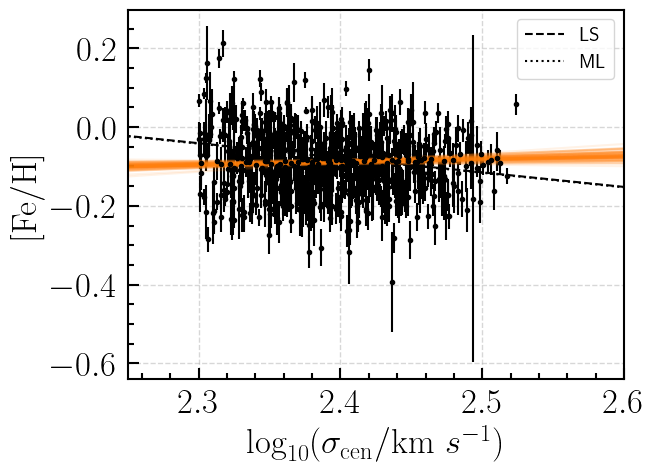

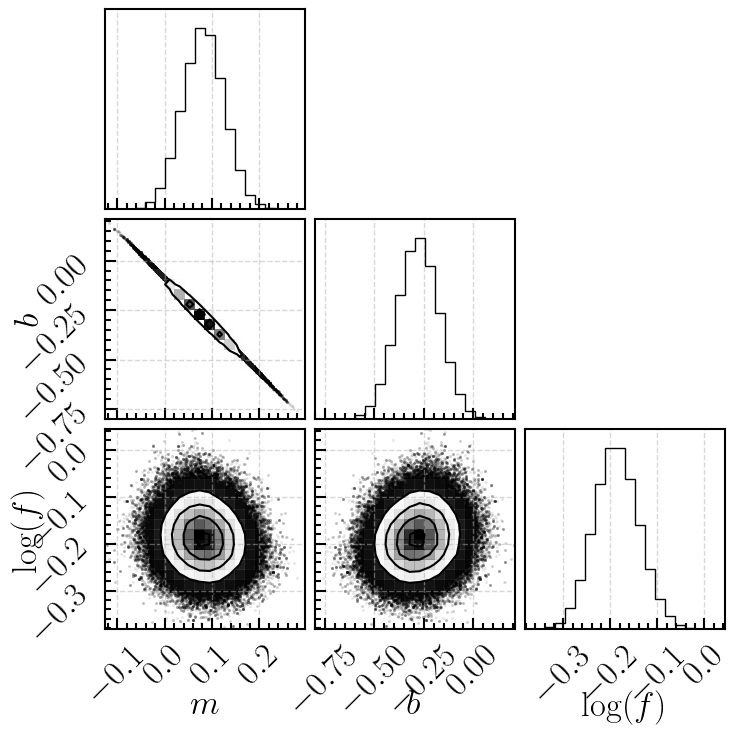

In [57]:
# Fit the data 
# sigma_cen - Fe/H relation
mask = (log_sig_cen > 2.3) & (log_sig_cen < 2.6)
labels = [r"$m$", r"$b$", r"$\log (f)$"]

# Central 
print("\n# sigma_cen v.s [Fe/H] relation -- Center")
fe_h_cen = emcee_fit(
    log_sig_cen[mask], fe_h[0][mask], fe_h_err[0][mask], verbose=False, 
    nburnin=500, nsteps=10000, nwalkers=64, thin=15, discard=500, y_label=r'$[{\rm Fe/H}]$')

fe_h_cen_ls, fe_h_cen_ml, fe_h_cen_samples, fe_h_cen_flat_samples, fe_h_cen_tau = fe_h_cen
fig = corner.corner(fe_h_cen_samples, labels=labels);

# sigma_cen v.s [Fe/H] relation -- Middle


100%|██████████| 10000/10000 [01:20<00:00, 124.37it/s]


$m=-0.10^{+0.07}_{-0.07}\quad b=0.06^{+0.17}_{-0.17}\quad \ln f=-0.88^{+0.04}_{-0.04}\quad $


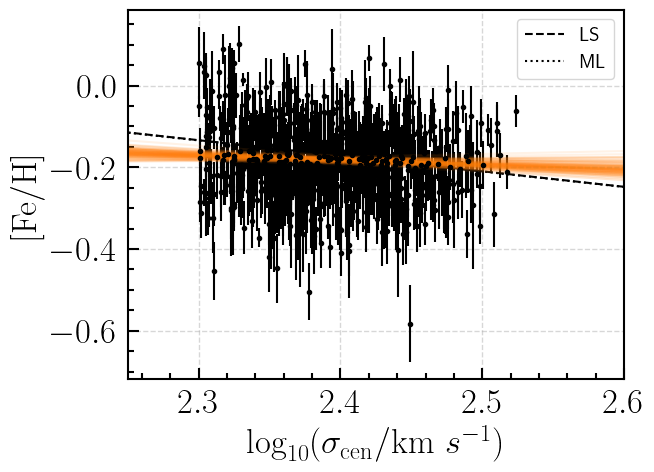

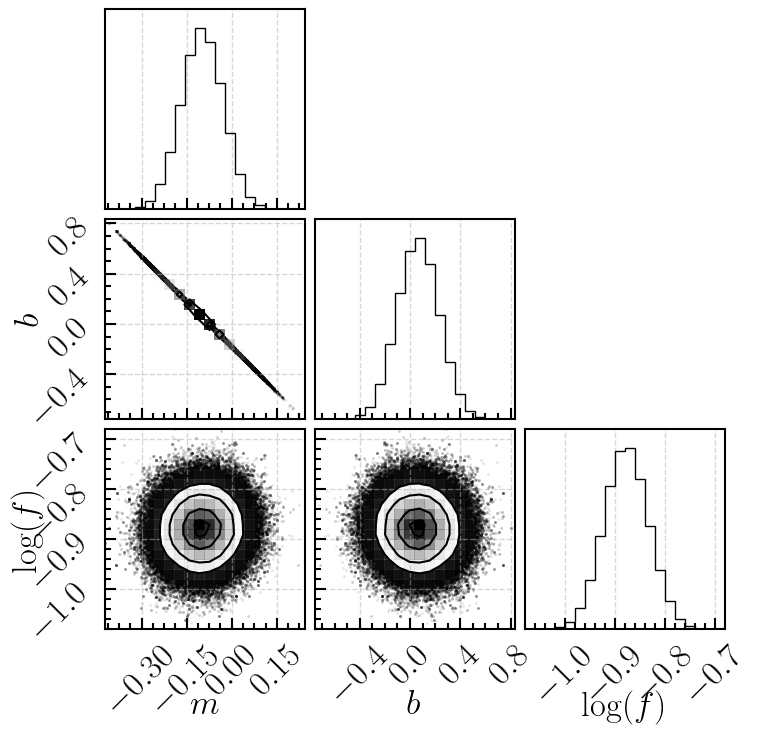

In [58]:
# Middle 
print("# sigma_cen v.s [Fe/H] relation -- Middle")
fe_h_cen = emcee_fit(
    log_sig_cen[mask], fe_h[1][mask], fe_h_err[1][mask], verbose=False, 
    nburnin=500, nsteps=10000, nwalkers=64, thin=15, discard=500, y_label=r'$[{\rm Fe/H}]$')

fe_h_cen_ls, fe_h_cen_ml, fe_h_cen_samples, fe_h_cen_flat_samples, fe_h_cen_tau = fe_h_cen
fig = corner.corner(fe_h_cen_samples, labels=labels);

# sigma_cen v.s [Fe/H] relation -- Outer


100%|██████████| 10000/10000 [01:19<00:00, 126.38it/s]


$m=-0.21^{+0.09}_{-0.09}\quad b=0.27^{+0.22}_{-0.22}\quad \ln f=-1.20^{+0.07}_{-0.07}\quad $


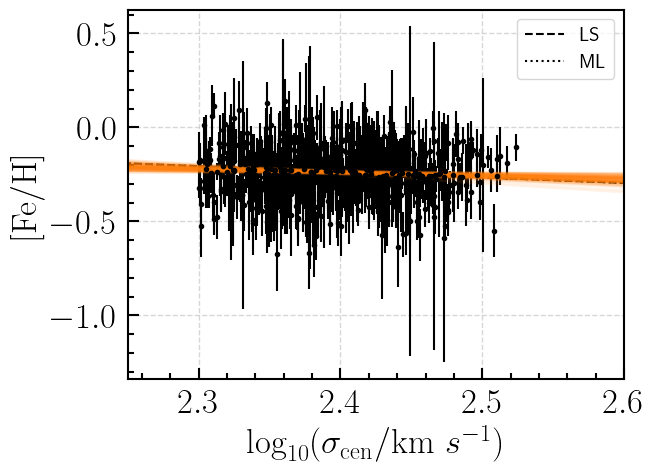

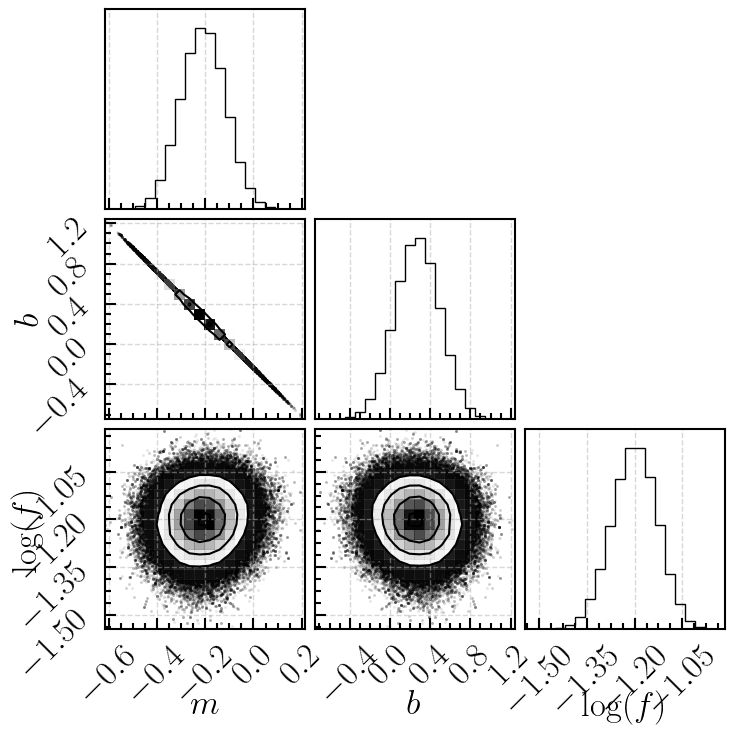

In [59]:
# Outer 
print("# sigma_cen v.s [Fe/H] relation -- Outer")
fe_h_cen = emcee_fit(
    log_sig_cen[mask], fe_h[2][mask], fe_h_err[2][mask], verbose=False, 
    nburnin=500, nsteps=10000, nwalkers=64, thin=15, discard=500, y_label=r'$[{\rm Fe/H}]$')

fe_h_cen_ls, fe_h_cen_ml, fe_h_cen_samples, fe_h_cen_flat_samples, fe_h_cen_tau = fe_h_cen
fig = corner.corner(fe_h_cen_samples, labels=labels);


# sigma_cen v.s [Fe/H] relation -- Center


100%|██████████| 10000/10000 [01:21<00:00, 122.23it/s]


$m=0.41^{+0.04}_{-0.04}\quad b=-0.69^{+0.09}_{-0.09}\quad \ln f=-2.04^{+0.04}_{-0.04}\quad $


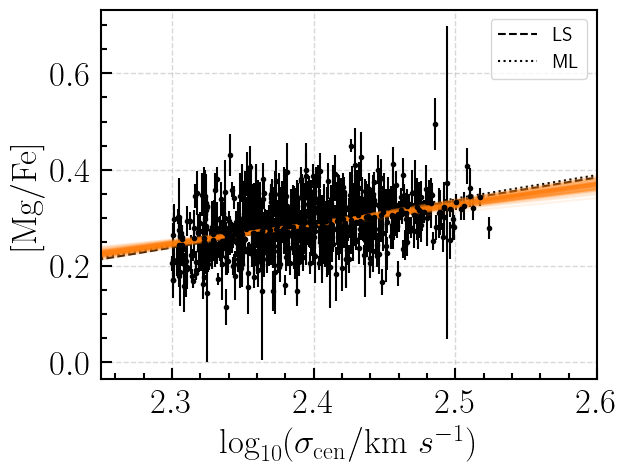

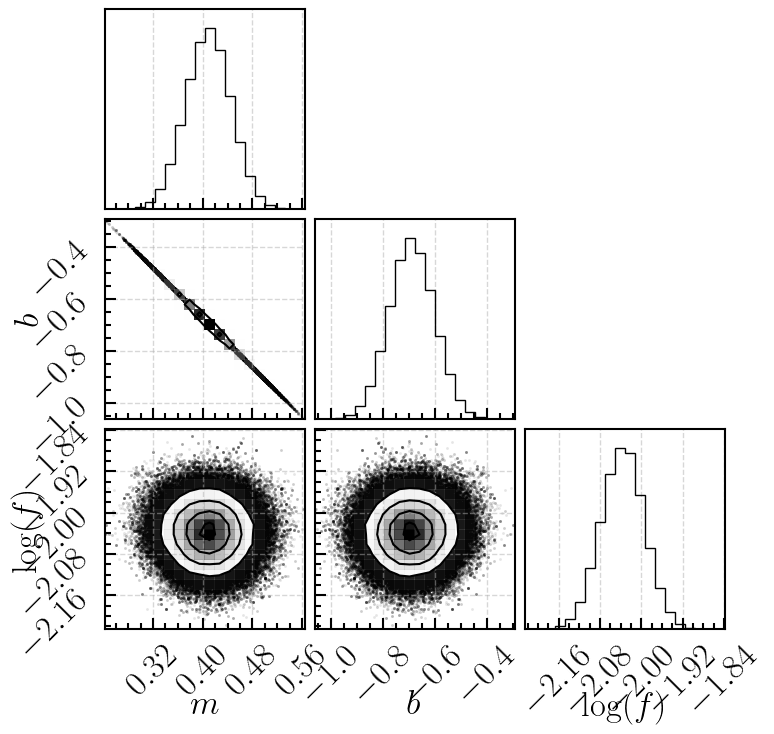

In [61]:
# sigma_cen - Mg/Fe relation

# Central 
print("\n# sigma_cen v.s [Fe/H] relation -- Center")
fe_h_cen = emcee_fit(
    log_sig_cen[mask], mg_fe[0][mask], mg_fe_err[0][mask], verbose=False, 
    nburnin=500, nsteps=10000, nwalkers=64, thin=15, discard=500, y_label=r'$[{\rm Mg/Fe}]$')

fe_h_cen_ls, fe_h_cen_ml, fe_h_cen_samples, fe_h_cen_flat_samples, fe_h_cen_tau = fe_h_cen
fig = corner.corner(fe_h_cen_samples, labels=labels);



# sigma_cen v.s [Fe/H] relation -- Middle


100%|██████████| 10000/10000 [01:20<00:00, 124.60it/s]


$m=0.47^{+0.05}_{-0.05}\quad b=-0.84^{+0.11}_{-0.11}\quad \ln f=-1.96^{+0.06}_{-0.06}\quad $


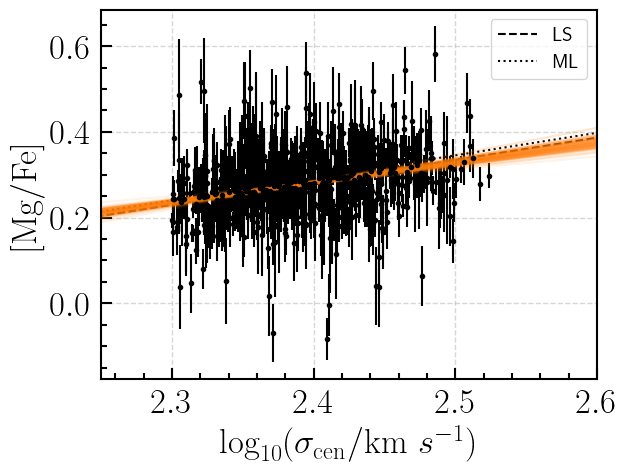

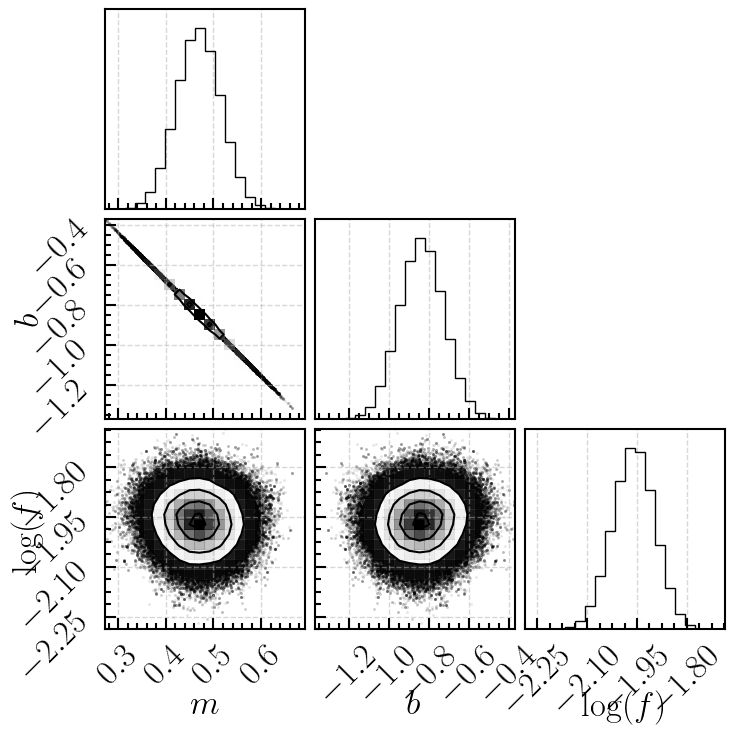

In [62]:
# Middle 
print("\n# sigma_cen v.s [Fe/H] relation -- Middle")
fe_h_cen = emcee_fit(
    log_sig_cen[mask], mg_fe[1][mask], mg_fe_err[1][mask], verbose=False, 
    nburnin=500, nsteps=10000, nwalkers=64, thin=15, discard=500, y_label=r'$[{\rm Mg/Fe}]$')

fe_h_cen_ls, fe_h_cen_ml, fe_h_cen_samples, fe_h_cen_flat_samples, fe_h_cen_tau = fe_h_cen
fig = corner.corner(fe_h_cen_samples, labels=labels);


# sigma_cen v.s [Fe/H] relation -- Outer


100%|██████████| 10000/10000 [01:20<00:00, 124.89it/s]


$m=0.41^{+0.08}_{-0.08}\quad b=-0.70^{+0.18}_{-0.18}\quad \ln f=-1.61^{+0.09}_{-0.09}\quad $


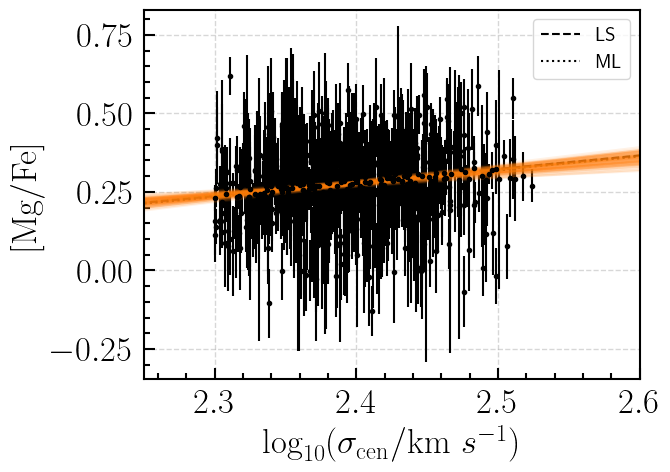

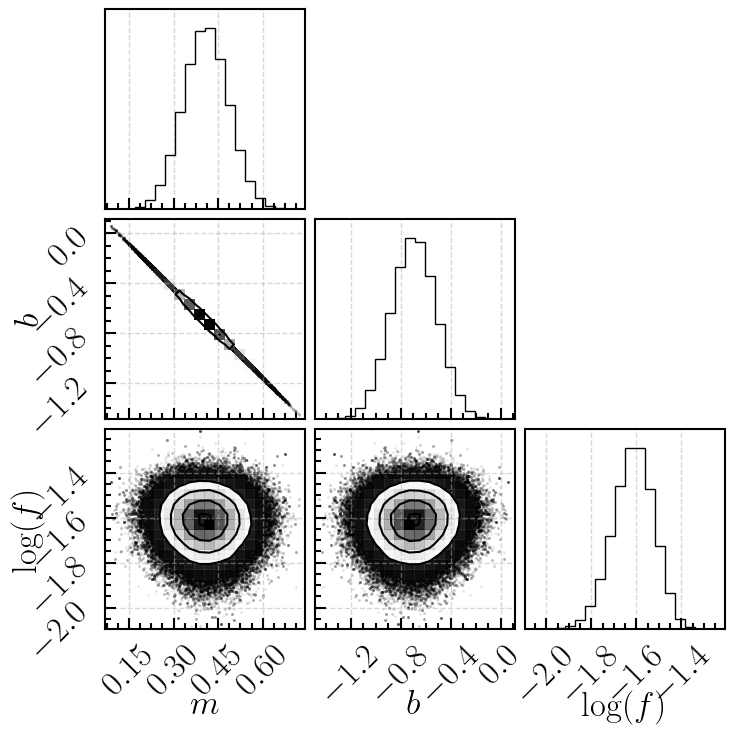

In [63]:
# Outer 
print("\n# sigma_cen v.s [Fe/H] relation -- Outer")
fe_h_cen = emcee_fit(
    log_sig_cen[mask], mg_fe[2][mask], mg_fe_err[2][mask], verbose=False, 
    nburnin=500, nsteps=10000, nwalkers=64, thin=15, discard=500, y_label=r'$[{\rm Mg/Fe}]$')

fe_h_cen_ls, fe_h_cen_ml, fe_h_cen_samples, fe_h_cen_flat_samples, fe_h_cen_tau = fe_h_cen
fig = corner.corner(fe_h_cen_samples, labels=labels);

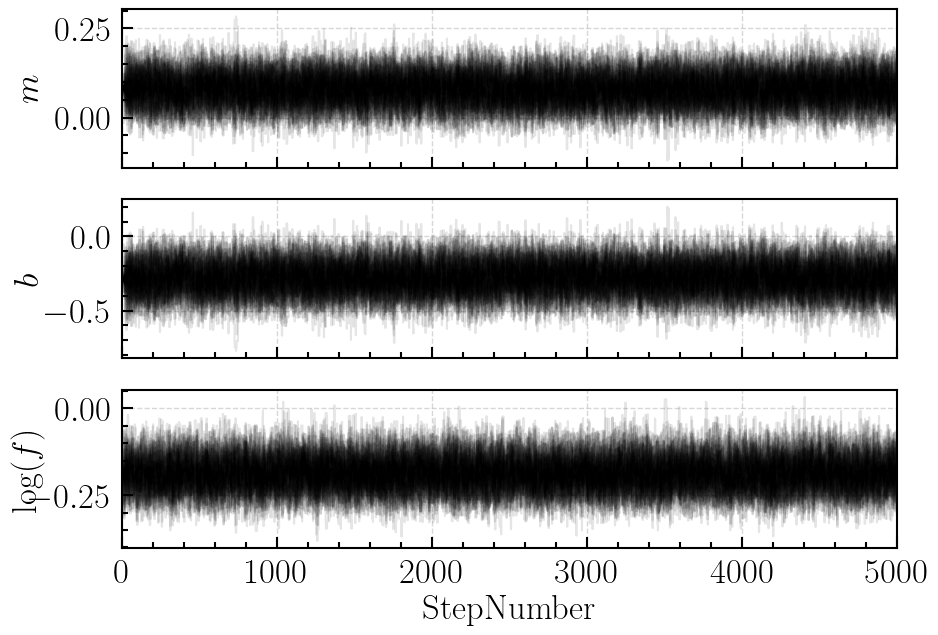

In [55]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot(fe_h_cen_samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(fe_h_cen_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel(r"$\rm Step Number$");